## Computer Vision Base Trainer

The basic steps we'll take are:

1. Importing our collected, organized, and cleaned images
1. Fine-tune a pretrained neural network to recognise these two groups
1. Try running this model on a picture from our test dataset and see if it works.

## STEP 0: Ensure you are running this notebook within a Docker Container

View the README.md file for instructions on building and running a container.

### STEP 1: Import the image data to the workspace so we can use them to train a model

The Docker container will create a nice `workspace` for us that we can recreate if we ever need to start over from scratch. This can allow us to try many different things from the same starting point if we want.

The folder structure for this workspace is
 - data (our collected data will be placed here)
 - images (other images we may need that is not the data)
 - models (models we choose to save will be stored here)
 - notebooks (the notebooks we run can be found in this directory)

Within our code, we can use both **absolute** and **relative** paths. This notebook is inside of the notebooks directory, and to reference a file in the data directory we can use the following options below:
 - absolute path: `/workspace/data/filename.zip`
 - relative path: `../data/filename.zip` (the `..` in this case means from where this file is, go up one directory)

The code below imports `zipfile` and `os` so that we can work with the filesystem. Take a close look at the comments for each line as explanations for what would happen when we run the code in that cell.

In [1]:
import zipfile
import os

# Define the path to the zip file and the extraction directory
zip_file_name = 'Juliana_Data_resized' # You will want to change this filename to the filename of your data
zip_file_path = f"/workspace/data/{zip_file_name}.zip" # You should not need to edit anything here because the zip_file_path references the variable containing the filename above, this code assumes it will be a zip file
extract_to_dir = '/workspace/data/' # This is where the extracted zip file will go, turning that one zip file into the directories and images files that we will need to work with for training

# Check if the TRAINING_DATA directory already exists
if not os.path.exists(extract_to_dir+zip_file_name): # If the directory with the real data doesn't exist, run the code inside this if statement. 
    # Create the extraction directory if it doesn't exist
    os.makedirs(extract_to_dir, exist_ok=True) # Since the directory does not exist, it needs to be created

    # Open the zip file and extract its contents
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref: # These two lines extract the data from the zip file, and place them in the defined path for the extract_to_dir variable
        zip_ref.extractall(extract_to_dir)

    print(f"Extracted all files to {extract_to_dir}") # Recall that print statments can be very useful, this print statement let's you know that the extraction process has completed
else: # This else block will only run if the directory with the real data already exists. If you need to unzip the data again, you will have to remove this directory inside the /workspace/data/ directory
    print(f"Directory {extract_to_dir} already exists. Skipping extraction.") # Since this block only runs if the directory already exists, it's helpful to get a message that it's already there


Directory /workspace/data/ already exists. Skipping extraction.


Depending on the size of your zipfile, and the amount of data you are importing, this may take a while. But once you have extracted the data, the Docker container is setup so that it will persist (stay around) when you come back to this notebook again.

## Step 2: Train our model

We will be using the FastAPI library from Fast.AI to train our models. Documentation for this library can be found at [https://docs.fast.ai/](https://docs.fast.ai/).

For our purposes, we will be working within the subset of the API for **Computer Vision**.
 - This means we do not need to import all of fast ai (`import fastai`).
 - Instead, we will just need to import the subset of the api for `vision` (`from fastai.vision.all import *`)
   - note that the `*` here means everything within `fastai.vision`

In [2]:
from fastai.vision.all import *

Now that we have access to the tools we will need for training, it can be helpful to set a variable for the `path` to where the data is stored. I often put mine in a directory called *TRAINING_DATA*, but yours should be the same as the zip file you unpacked above

For example, if my zipfile was named `IAN_DATA.zip` I would modify the assignment to path to be `path = /workspace/data/IAN_DATA`. The `.zip` is dropped here because we are looking at the full directory that was unpacked, and not the compressed file.

In [3]:
path = '/workspace/data/Juliana_Data_resized'

Now that the location of the data is set in a variable, we might want to verify that all of our data is image data. If you have collected all of the data and are confident you don't have any random files in the directories, you may not need this. But, it can be helpful to run it once to ensure we won't have filetype issues going forward.

In [4]:
# only run this test if you've added new data to the training data
# it does NOT need to be run if you're confident that the image files are valid 
failed = verify_images(get_image_files(path)) # this looks at all of the files in our defined path and verifies that they are images, and failures will be placed in the failed variable
failed.map(Path.unlink) # if there are any failes that were not images, remove them from the data
len(failed) # show the number of failed files, ideally this will be 0, but even if it's more than 0 know that those files are now gone and we don't need to worry about them

0

To train a model, we'll need `DataLoaders`, which is an object that contains a *training set* (the images used to create a model) and a *validation set* (the images used to check the accuracy of a model -- not used during training). In `fastai` we can create that easily using a `DataBlock`, and view sample images from it:

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████████████████████████████████████████████████████████████████████████| 97.8M/97.8M [00:05<00:00, 20.4MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

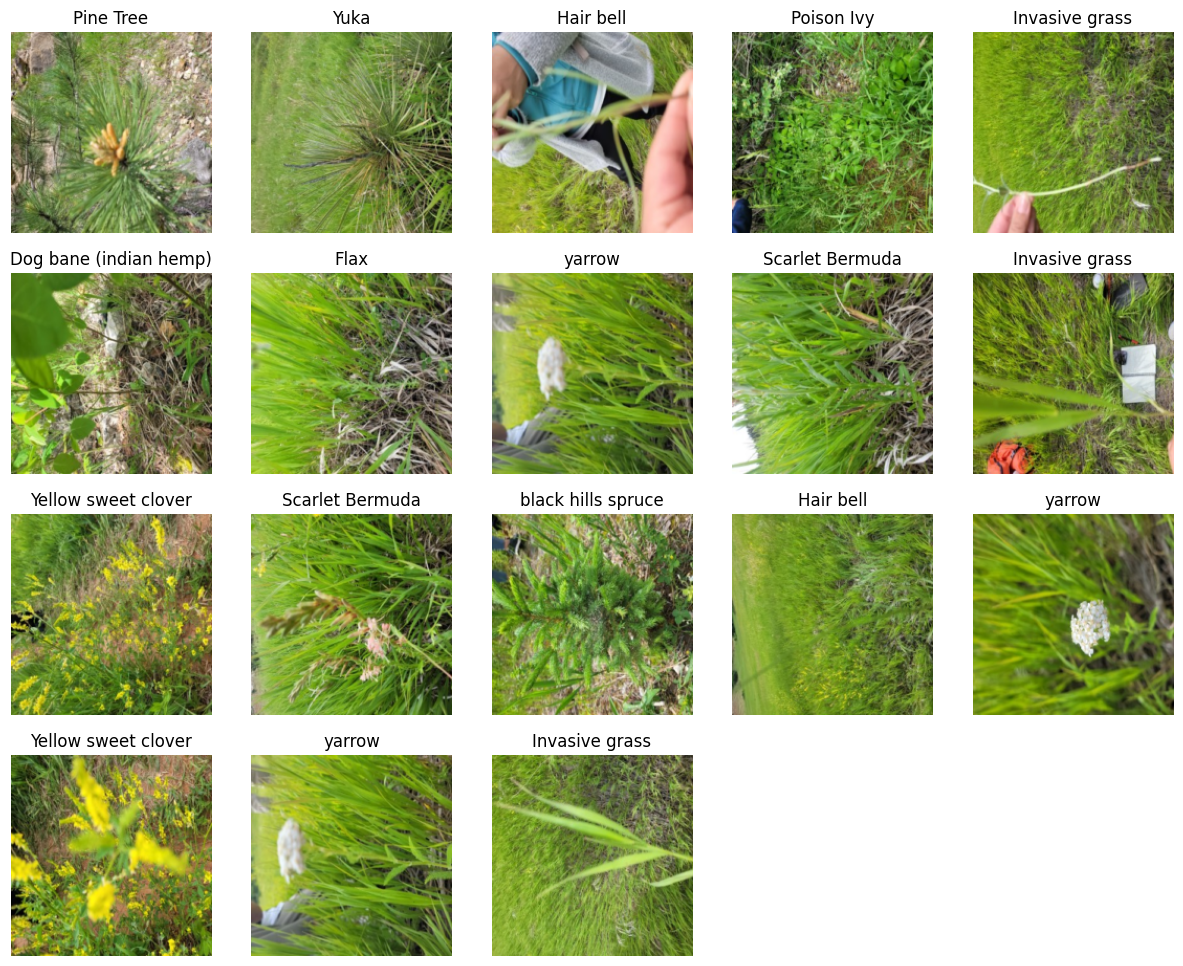

In [26]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=256)

dls.show_batch(max_n=18)

def __init__(self, saturation_factor):
        self.saturation_factor = saturation_factor

def __call__(self, x):
        # Convert PIL image to numpy array
        x = np.array(x)
models.resnet50(pretrained=True)

Here what each of the `DataBlock` parameters means:

    blocks=(ImageBlock, CategoryBlock),

The inputs to our model are images, and the outputs are categories (in this case, "bird" or "forest").

    get_items=get_image_files, 

To find all the inputs to our model, run the `get_image_files` function (which returns a list of all image files in a path).

    splitter=RandomSplitter(valid_pct=0.2, seed=42),

Split the data into training and validation sets randomly, using 20% of the data for the validation set.

    get_y=parent_label,

The labels (`y` values) is the name of the `parent` of each file (i.e. the name of the folder they're in, which will be the names of each plant).

    item_tfms=[Resize(192, method='squish')]

Before training, resize each image to 192x192 pixels by "squishing" it (as opposed to cropping it).

    aug_transforms(size=224)

Data augmentation transformations, in this case, changing the output size to 224.

Now we're ready to train our model. The fastest widely used computer vision model is `resnet18`, which is a pre-trained model that already works for other images. You can train this in a few minutes, even on a CPU! (On a GPU, it generally takes under 10 seconds...)

`fastai` comes with a helpful `fine_tune()` method which automatically uses best practices for fine tuning a pre-trained model, so we'll use that.

In [27]:
learn = vision_learner(dls, resnet18, metrics=error_rate)

# if you want to load in a previously trained model, use the code below to load a previously trained model
# this may be useful if you want to continue training on that model with out starting over
# for example, if you've run 50 epochs while fine tuning and don't want to start at 0 again
# learn = load_learner('model.pkl')

SuggestedLRs(valley=0.0020892962347716093)

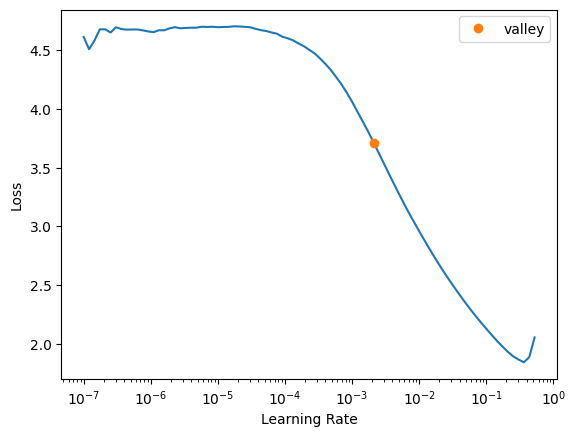

In [28]:
learn.lr_find()

"Fine-tuning" a model means that we're starting with a model someone else has trained using some other dataset (called the *pretrained model*), and adjusting the weights a little bit so that the model learns to recognise your particular dataset. In this case, the pretrained model was trained to recognise photos in *imagenet*, and widely-used computer vision dataset with images covering 1000 categories) For details on fine-tuning and why it's important, check out the [free fast.ai course](https://course.fast.ai/).

In [29]:
epochs = 1
learn.fine_tune(epochs, base_lr=0.0020892962347716093) #use the value from the lr_find() method above

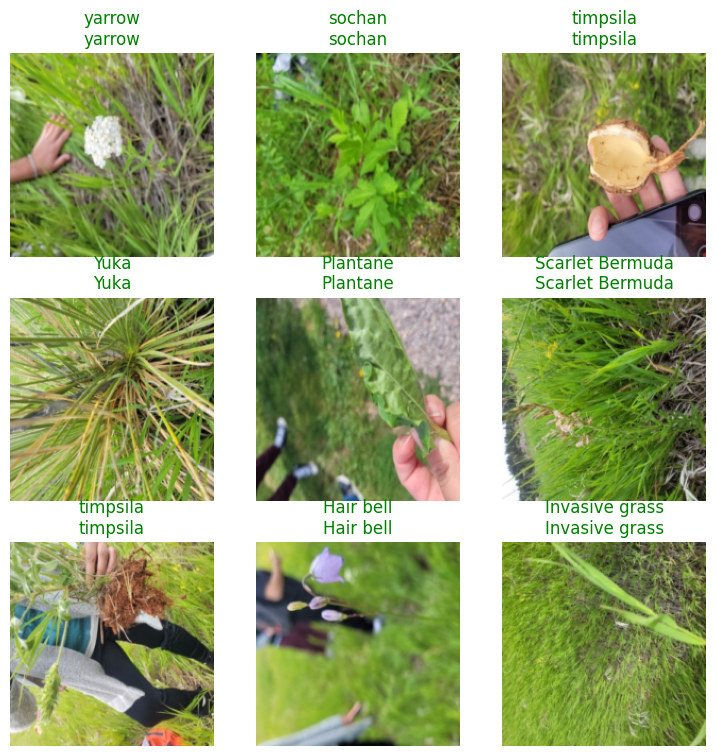

In [30]:
learn.show_results()

## Step 3: Let's see how our model did and what did it had the most difficulty with

In [31]:
interp = ClassificationInterpretation.from_learner(learn)

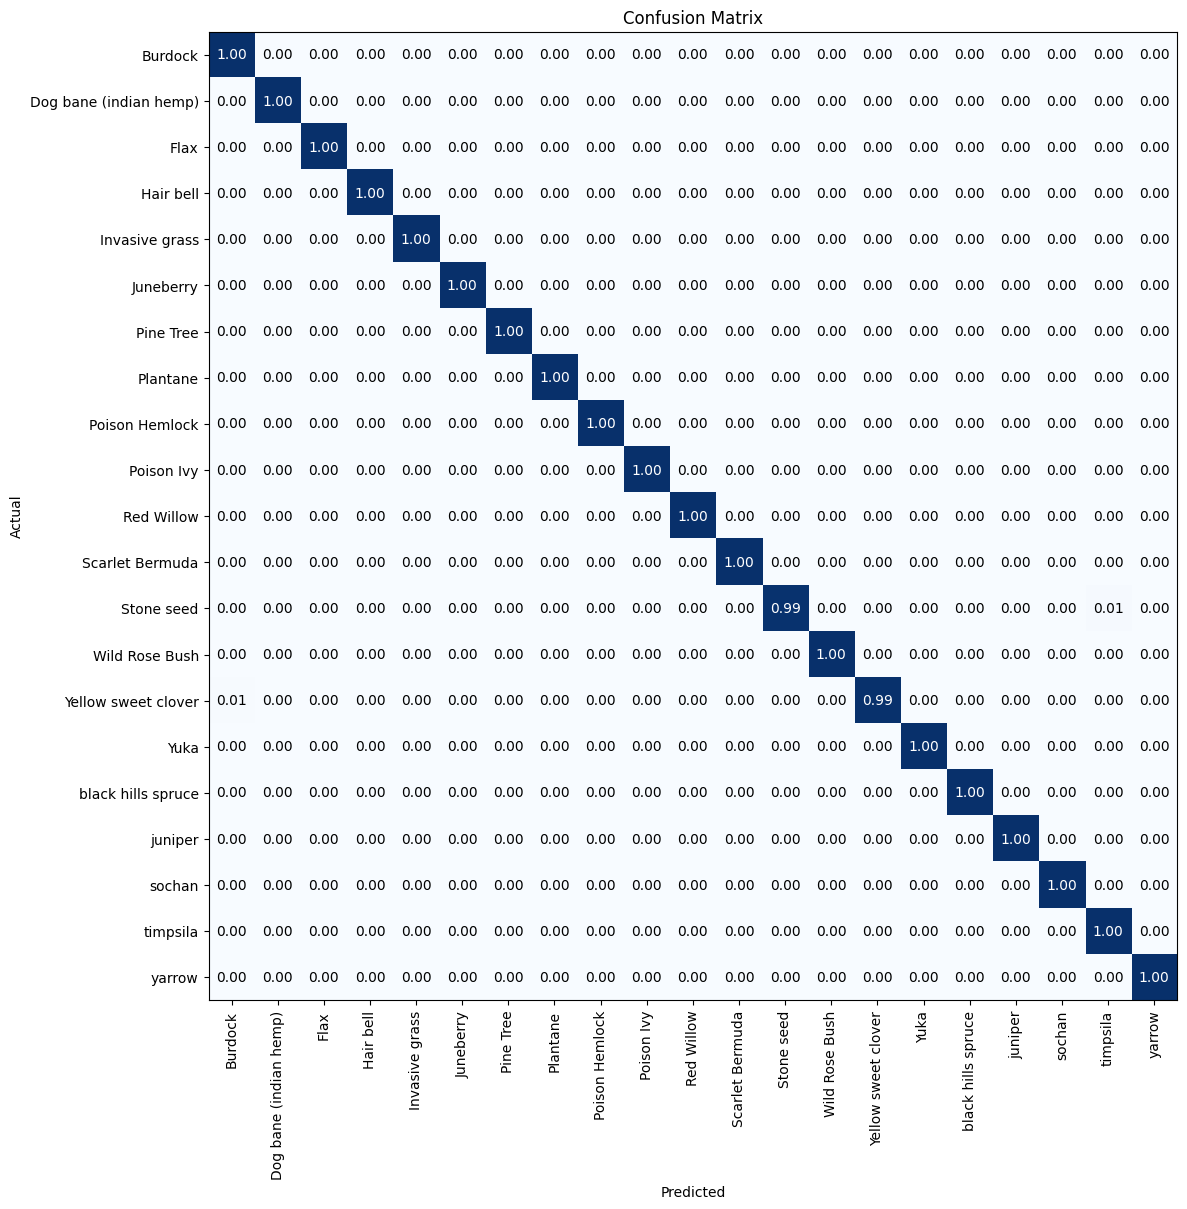

In [32]:
interp.plot_confusion_matrix(normalize=true, title='Confusion Matrix', figsize=(12, 12))

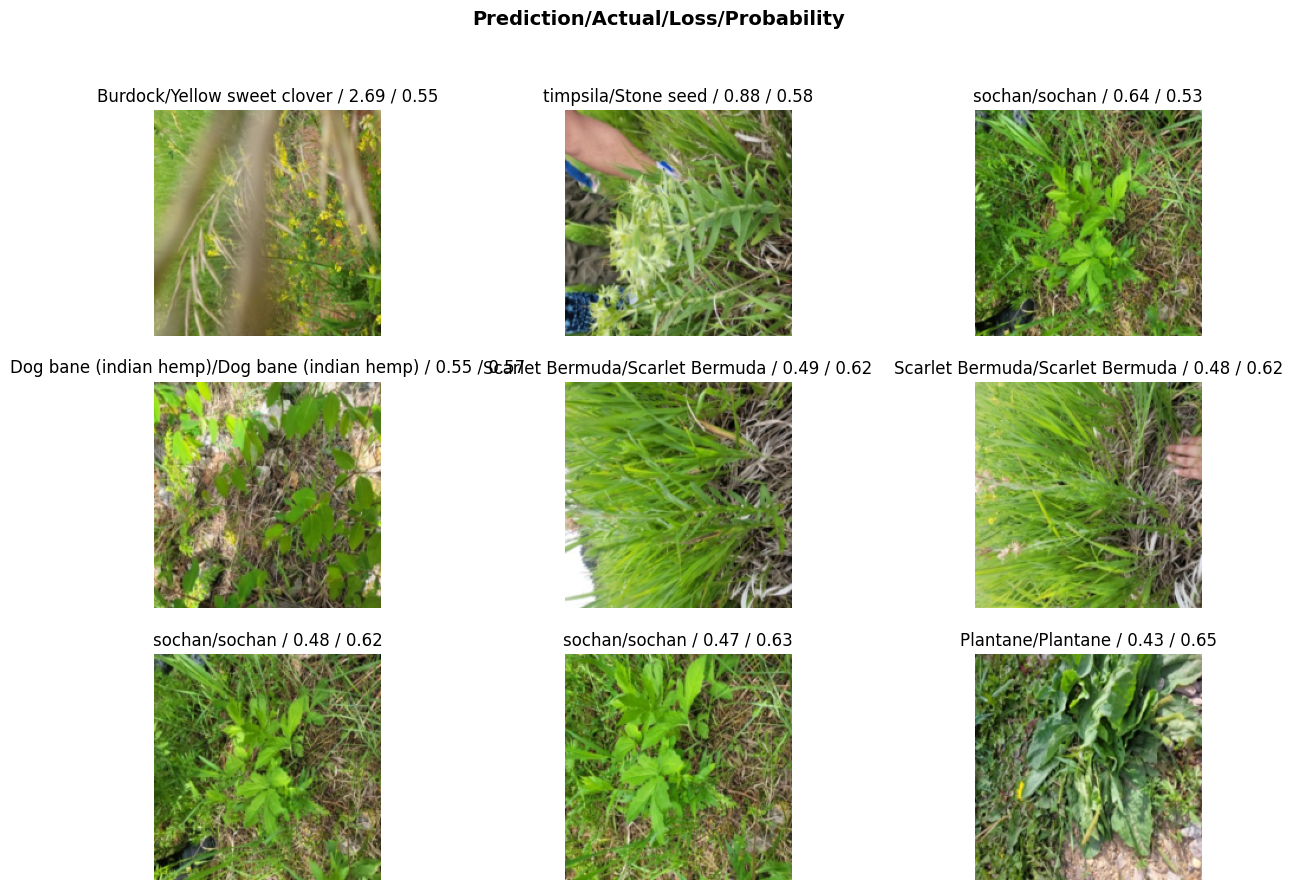

In [33]:
interp.plot_top_losses(9, figsize=(15,10))

## Step 4: Let's clean the data

In [34]:
from fastai.vision.widgets import ImageClassifierCleaner
cleaner = ImageClassifierCleaner(learn)
cleaner

In [35]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

If you are satisfied with your trained `Learner`, then you can export the file that contains all the information needed to run the model:

In [36]:
learn.export('../models/model.pkl')